In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

Use this dataset of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.  

http://stat-computing.org/dataexpo/2009/the-data.html

	Name	Description
1	Year	1987-2008  
2	Month	1-12  
3	DayofMonth	1-31  
4	DayOfWeek	1 (Monday) - 7 (Sunday)  
5	DepTime	actual departure time (local, hhmm)  
6	CRSDepTime	scheduled departure time (local, hhmm)  
7	ArrTime	actual arrival time (local, hhmm)  
8	CRSArrTime	scheduled arrival time (local, hhmm)  
9	UniqueCarrier	unique carrier code  
10	FlightNum	flight number  
11	TailNum	plane tail number  
12	ActualElapsedTime	in minutes  
13	CRSElapsedTime	in minutes  
14	AirTime	in minutes  
15	ArrDelay	arrival delay, in minutes  
16	DepDelay	departure delay, in minutes  
17	Origin	origin IATA airport code  
18	Dest	destination IATA airport code  
19	Distance	in miles  
20	TaxiIn	taxi in time, in minutes  
21	TaxiOut	taxi out time in minutes  
22	Cancelled	was the flight cancelled?  
23	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)  
24	Diverted	1 = yes, 0 = no  
25	CarrierDelay	in minutes  
26	WeatherDelay	in minutes  
27	NASDelay	in minutes  
28	SecurityDelay	in minutes  
29	LateAircraftDelay	in minutes  


In [ ]:
import random
skp_lines = random.sample(range(1, 1000000), 100000)
df_all = pd.read_csv('2008.csv', nrows = 10000000)#skiprows = lambda x: x in skp_lines)
df = df_all.sample(frac=0.01, replace=False)

In [3]:
# df = pd.read_csv('2008.csv', skp_lines = lambda x: x in skp_lines)

df = df[df['Cancelled']==0]
df = df[df['Diverted']==0]

In [4]:
df['late'] = [1 if arrdelay >30 else 0 for arrdelay in df.ArrDelay]

In [5]:
for delay in ['CarrierDelay','LateAircraftDelay','WeatherDelay','NASDelay', 'SecurityDelay']:
    df[delay].fillna(0, inplace=True)

In [6]:
df2 = df.loc[:, ~df.columns.isin(['FlightNum','Year', 'TailNum','CancellationCode','Cancelled', 'Diverted'])]

break_out = ['DayOfWeek', 'Month','UniqueCarrier','Dest','Origin']
for col in break_out:
    df2 = pd.concat([df2, pd.get_dummies(df2[col],prefix=col)], axis=1)

df2 = df2.dropna()
X = df2.loc[:, ~df2.columns.isin(break_out+['late'])]

y = df2['late']

print('initial number of rows:', len(df),'\nnumber of rows removed:', len(df)-len(X))

initial number of rows: 68548 
number of rows removed: 0


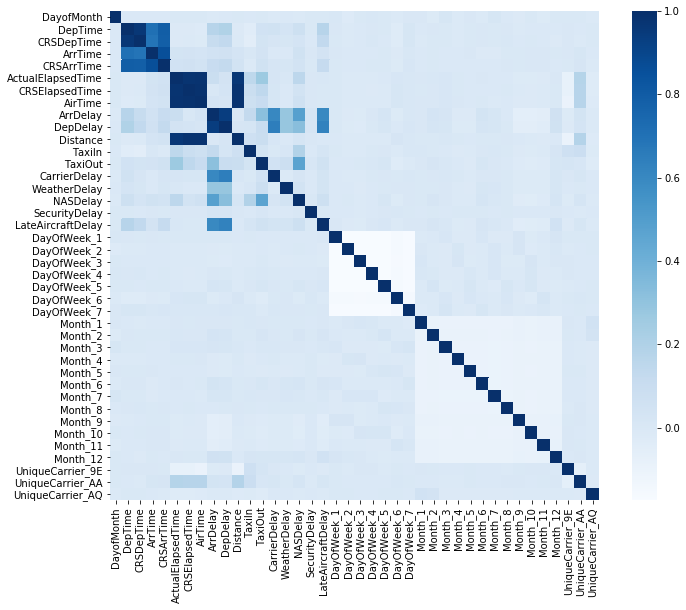

In [39]:
corrmat = X[X.columns[0:40]].corr()#alt_X_df.corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True, annot=False,cmap='Blues')

Let's see... we need:  
- a classifier that can handle many variables (decision tree, random forrest: both out)  
- a training set that includes all carriers, destinations, and origins.   


In [7]:
X_test,X_train, y_test,y_train = train_test_split(X,y)

## Gradient Boosting Classifier

In [41]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 100,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0


In [42]:
print('model score:', clf.score(X_test, y_test),'\n% of predictions that were late:', 100*sum(predict_test)/len(predict_test), '\n% actual flights that were late:', 100*sum(y_test)/len(y_test))
      

model score: 1.0 
% of predictions that were late: 12.9984423676 
% actual flights that were late: 12.998442367601246


In [43]:
X.shape

(68480, 649)

## SVM Classifier

In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
svc = SVC()

NameError: name 'X_train' is not defined

In [9]:
# svc.fit(X_train, y_train)

# predict_train = svc.predict(X_train)
# predict_test = svc.predict(X_test)

svc.fit(scaler.transform(X_train), y_train)

predict_train = svc.predict(scaler.transform(X_train))
predict_test = svc.predict(scaler.transform(X_test))

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.00011670654140164556

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.13232576685923245


In [10]:
print('model score:', svc.score(X_test, y_test),'\n% of predictions that were late:', 100*sum(predict_test)/len(predict_test), '\n% actual flights that were late:', 100*sum(y_test)/len(y_test))

model score: 0.867674233141 
% of predictions that were late: 0.00194510902336 
% actual flights that were late: 13.234521794946607


## Logistic Regression

In [44]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression()

In [45]:
logreg.fit(X_train, y_train)

predict_train = logreg.predict(X_train)
predict_test = logreg.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set accuracy:
Percent Type I errors: 0.004964953271028037
Percent Type II errors: 0.004672897196261682

Test set accuracy:
Percent Type I errors: 0.006191588785046729
Percent Type II errors: 0.005120716510903427


In [46]:
print('model score:', logreg.score(X_test, y_test),'\n% of predictions that were late:', 100*sum(predict_test)/len(predict_test), '\n% actual flights that were late:', 100*sum(y_test)/len(y_test))

model score: 0.988687694704 
% of predictions that were late: 13.105529595 
% actual flights that were late: 12.998442367601246
